In [37]:
import pandas as pd
import numpy as np
import json

In [152]:
df = pd.read_csv('pitt_restaurants.csv')

In [145]:
# get zipcodes with at least 50 restaurants in them
count_zip = df.groupby('location.zip_code').size()
count_zip = count_zip.reset_index().rename(columns={0: 'counts'}).sort_values('counts', ascending=False)
zipcodes = count_zip[count_zip['counts'] >= 50]['location.zip_code'].to_list()

# only keep restaurants from those zipcodes
df = df[df['location.zip_code'].isin(zipcodes)]

In [153]:
def col_to_json(df, column):
  df[column] = df[column].str.replace("\'", "\"")
  df[column] = df[column].apply(json.loads)

col_to_json(df, 'categories')
col_to_json(df, 'transactions')
df = df.explode('categories')
df['categories'] = df['categories'].apply(lambda x: x['title'])

df = df.explode('transactions')

# map price to ordinal values 
df['price'] = df['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$': 4})

df['rating'] = df['rating'].apply(lambda x: int(x*2))

# drop unneeded columns
df = df.drop(columns=['id', 'alias', 'name', 'display_phone', 'location.address1', 'location.address2', 'location.address3', 'image_url', 'url', 'phone', 'location.city', 'location.country', 'location.state', 'location.display_address'])

# transform text features into indicator variables
df = pd.get_dummies(df, columns=['transactions', 'categories'])

df = df.dropna()


In [154]:
df

,is_closed,review_count,rating,price,distance,coordinates.latitude,coordinates.longitude,location.zip_code,transactions_delivery,transactions_pickup,...,categories_Vegetarian,categories_Venezuelan,categories_Venues & Event Spaces,categories_Vietnamese,categories_Waffles,categories_Whiskey Bars,categories_Wine Bars,categories_Wine Tasting Room,categories_Wineries,categories_Wraps
0,False,171,9,2.0,2772.458381,40.391533,-80.087645,15106,1,0,...,0,0,0,0,0,0,0,0,0,0
0,False,171,9,2.0,2772.458381,40.391533,-80.087645,15106,1,0,...,0,0,0,0,0,0,0,0,0,0
0,False,171,9,2.0,2772.458381,40.391533,-80.087645,15106,1,0,...,0,0,0,0,0,0,0,0,0,0
1,False,195,9,1.0,2337.596638,40.407761,-80.086108,15106,1,0,...,0,0,0,0,0,0,0,0,0,0
1,False,195,9,1.0,2337.596638,40.407761,-80.086108,15106,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,False,30,5,1.0,3188.436217,40.538324,-79.834410,15238,1,0,...,0,0,0,0,0,0,0,0,0,0
1426,False,14,5,2.0,2336.101540,40.535172,-79.844343,15238,0,1,...,0,0,0,0,0,0,0,0,0,0
1426,False,14,5,2.0,2336.101540,40.535172,-79.844343,15238,1,0,...,0,0,0,0,0,0,0,0,0,0
1426,False,14,5,2.0,2336.101540,40.535172,-79.844343,15238,0,1,...,0,0,0,0,0,0,0,0,0,0


In [155]:
x = df.drop(columns='rating')
y = df['rating']

feature_names = x.columns
labels = y.unique()

In [156]:
from sklearn.model_selection import train_test_split

X_train, test_x, y_train, test_lab = train_test_split(x,y,test_size = 0.4,random_state = 42)

In [180]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10, random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

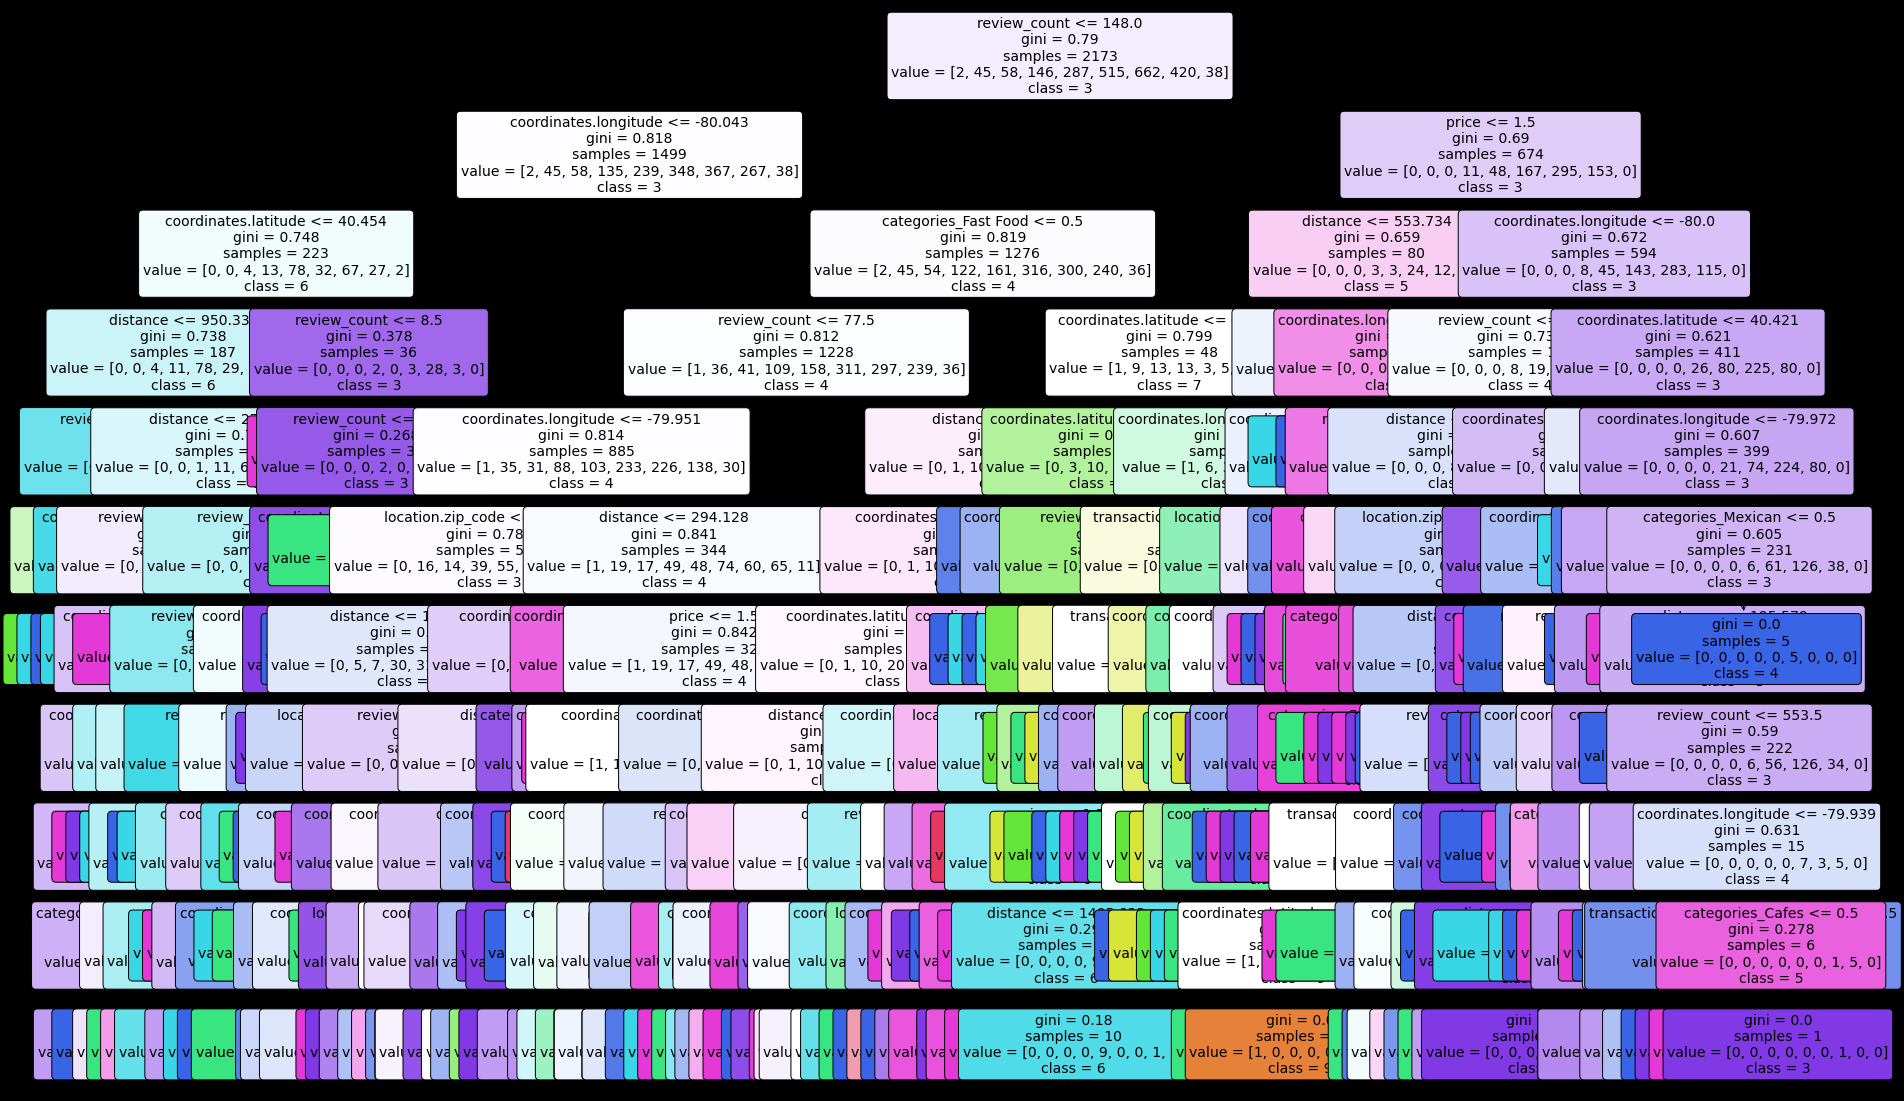

In [181]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,20), facecolor='k')


a = tree.plot_tree(clf, feature_names=feature_names, class_names=[str(x) for x in labels], rounded=True, filled=True, fontsize=14)
plt.show()

In [184]:
from sklearn.tree import export_text
tree_rules = export_text(clf, feature_names=list(feature_names))
print(tree_rules)

|--- review_count <= 148.00
|   |--- coordinates.longitude <= -80.04
|   |   |--- coordinates.latitude <= 40.45
|   |   |   |--- distance <= 950.34
|   |   |   |   |--- review_count <= 36.50
|   |   |   |   |   |--- distance <= 702.71
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- distance >  702.71
|   |   |   |   |   |   |--- class: 6
|   |   |   |   |--- review_count >  36.50
|   |   |   |   |   |--- coordinates.latitude <= 40.42
|   |   |   |   |   |   |--- class: 7
|   |   |   |   |   |--- coordinates.latitude >  40.42
|   |   |   |   |   |   |--- class: 6
|   |   |   |--- distance >  950.34
|   |   |   |   |--- distance <= 2736.84
|   |   |   |   |   |--- review_count <= 127.00
|   |   |   |   |   |   |--- coordinates.latitude <= 40.44
|   |   |   |   |   |   |   |--- coordinates.latitude <= 40.43
|   |   |   |   |   |   |   |   |--- review_count <= 13.00
|   |   |   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |   |   |--- review_count >  13.00


In [182]:
from sklearn import metrics

test_pred_decision_tree = clf.predict(test_x)
metrics.accuracy_score(test_lab, test_pred_decision_tree)

0.5455172413793103

In [188]:
#get the precision score
precision = metrics.precision_score(test_lab,
                                   test_pred_decision_tree,
                                   zero_division=0,
                                   average=None)
#turn it into a dataframe
precision_results = pd.DataFrame(precision, index=labels)
#rename the results column
precision_results.rename(columns={0:'precision'}, inplace =True)
precision_results

,precision
9,0.000000
8,0.150000
7,0.500000
10,0.510638
6,0.548387
4,0.496881
3,0.558052
5,0.684211
2,0.555556
